In [1]:
from bitarray import bitarray
import random
import numpy as np
import math
import timeit

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [4]:
import pandas as pd
import os

In [5]:
import sklearn.datasets as skds
from sklearn.datasets import fetch_openml

In [6]:
file = pd.read_csv("heart.csv")
file.head()
file.values

array([[63.,  1.,  3., ...,  0.,  1.,  1.],
       [37.,  1.,  2., ...,  0.,  2.,  1.],
       [41.,  0.,  1., ...,  0.,  2.,  1.],
       ...,
       [68.,  1.,  0., ...,  2.,  3.,  0.],
       [57.,  1.,  0., ...,  1.,  3.,  0.],
       [57.,  0.,  1., ...,  1.,  2.,  0.]])

In [7]:
X = np.array(file.values[:,:-1])
X = StandardScaler().fit_transform(X)
y = np.array(file.values[:,-1]).reshape(-1,1).astype(int)

In [8]:
x_neg=X[165:303]
x_pos=X[0:165]
y_pos=y[y==1]
y_neg=y[y==0]
np.random.shuffle(x_neg)
print(x_neg.shape)
print(x_pos.shape)

(138, 13)
(165, 13)


In [9]:
indices=np.arange(69)
#x_train=np.array(x_neg[0:106])[indices]
y_train=y_neg[0:69]
x_train=np.concatenate((np.array(x_neg[0:69])[indices],x_pos)).reshape(-1,13)
y_train=np.concatenate((y_train,y_pos)).reshape(-1,1)

In [10]:
x_test = x_neg[69:138].reshape(-1,13)
y_test = y_neg[69:138].reshape(-1,1)

# Standard Bloom Filter

In [11]:
from bitarray import bitarray
import mmh3
import random
import numpy as np
import math

In [12]:
class BloomFilter:
    
    def __init__(self, size, hash_count):
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)
        
    def add(self, num):
        for seed in range(1,self.hash_count+1):
            result = mmh3.hash(str(num), seed) % self.size
            self.bit_array[result] = 1
            
    def lookup(self, num):
        for seed in range(1,self.hash_count+1):
            result = mmh3.hash(str(num), seed) % self.size
            if self.bit_array[result] == 0:
                return False
        return True

# Projection model

In [13]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1
       # print(vectors)        
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

In [14]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values,times,standard_times):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        start1 = timeit.default_timer()
        
        stanbf = BloomFilter(m,k)
        for x_pos_i in x_pos:
            stanbf.add(sum(x_pos_i))
        
        stop1 = timeit.default_timer()
        
        start = timeit.default_timer()
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        stop = timeit.default_timer()
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f - Time Taken to create Standard: %f - Time Taken to create Projecion: %f \n\n\n" % (m,fpr_test,stop1-start1,stop-start))
        fpr_values += [fpr_test]
        size_values += [m]
        times += [stop-start]
        standard_times += [stop1-start1]

In [15]:
num_of_iterations = 20 #Increase to make graph smoother

fpr_values = []
size_values = []
times = []
standard_times = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,10,10,300,100,fpr_values,size_values,times,standard_times)

~~~~~~~~ Iteration 1 ~~~~~~~~ 

(165, 13)
Size: 10 Bits - FPR: 0.840580 - Time Taken to create Standard: 0.001326 - Time Taken to create Projecion: 0.040757 



Size: 20 Bits - FPR: 0.869565 - Time Taken to create Standard: 0.000759 - Time Taken to create Projecion: 0.040350 



Size: 30 Bits - FPR: 0.623188 - Time Taken to create Standard: 0.000747 - Time Taken to create Projecion: 0.040009 



Size: 40 Bits - FPR: 0.739130 - Time Taken to create Standard: 0.000817 - Time Taken to create Projecion: 0.040152 



Size: 50 Bits - FPR: 0.840580 - Time Taken to create Standard: 0.000778 - Time Taken to create Projecion: 0.041856 



Size: 60 Bits - FPR: 0.623188 - Time Taken to create Standard: 0.000765 - Time Taken to create Projecion: 0.041833 



Size: 70 Bits - FPR: 0.652174 - Time Taken to create Standard: 0.000743 - Time Taken to create Projecion: 0.038884 



Size: 80 Bits - FPR: 0.681159 - Time Taken to create Standard: 0.000734 - Time Taken to create Projecion: 0.037846 



Size: 

Size: 710 Bits - FPR: 0.144928 - Time Taken to create Standard: 0.000919 - Time Taken to create Projecion: 0.047463 



Size: 720 Bits - FPR: 0.115942 - Time Taken to create Standard: 0.001076 - Time Taken to create Projecion: 0.052504 



Size: 730 Bits - FPR: 0.144928 - Time Taken to create Standard: 0.001064 - Time Taken to create Projecion: 0.050286 



Size: 740 Bits - FPR: 0.159420 - Time Taken to create Standard: 0.001082 - Time Taken to create Projecion: 0.049403 



Size: 750 Bits - FPR: 0.086957 - Time Taken to create Standard: 0.001081 - Time Taken to create Projecion: 0.048204 



Size: 760 Bits - FPR: 0.173913 - Time Taken to create Standard: 0.001138 - Time Taken to create Projecion: 0.056026 



Size: 770 Bits - FPR: 0.159420 - Time Taken to create Standard: 0.001140 - Time Taken to create Projecion: 0.047609 



Size: 780 Bits - FPR: 0.130435 - Time Taken to create Standard: 0.001085 - Time Taken to create Projecion: 0.052899 



Size: 790 Bits - FPR: 0.086957 - Time Ta


Size: 1400 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001470 - Time Taken to create Projecion: 0.067232 



Size: 1410 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001390 - Time Taken to create Projecion: 0.074979 



Size: 1420 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001635 - Time Taken to create Projecion: 0.064205 



Size: 1430 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001582 - Time Taken to create Projecion: 0.066458 



Size: 1440 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001528 - Time Taken to create Projecion: 0.071310 



Size: 1450 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001623 - Time Taken to create Projecion: 0.066119 



Size: 1460 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.002060 - Time Taken to create Projecion: 0.066891 



Size: 1470 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001532 - Time Taken to create Projecion: 0.071427 



Size: 1480 Bits - FPR: 0.014493

Size: 2100 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001953 - Time Taken to create Projecion: 0.084278 



Size: 2110 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001847 - Time Taken to create Projecion: 0.074596 



Size: 2120 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001823 - Time Taken to create Projecion: 0.081407 



Size: 2130 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001832 - Time Taken to create Projecion: 0.080857 



Size: 2140 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001998 - Time Taken to create Projecion: 0.082158 



Size: 2150 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.002652 - Time Taken to create Projecion: 0.087229 



Size: 2160 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.002280 - Time Taken to create Projecion: 0.083129 



Size: 2170 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001978 - Time Taken to create Projecion: 0.080169 



Size: 2180 Bits - FPR: 0.000000 

Size: 2780 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002194 - Time Taken to create Projecion: 0.105497 



Size: 2790 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002244 - Time Taken to create Projecion: 0.091027 



Size: 2800 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002575 - Time Taken to create Projecion: 0.081482 



Size: 2810 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.002820 - Time Taken to create Projecion: 0.108315 



Size: 2820 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002252 - Time Taken to create Projecion: 0.094803 



Size: 2830 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002197 - Time Taken to create Projecion: 0.087034 



Size: 2840 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002247 - Time Taken to create Projecion: 0.087592 



Size: 2850 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002262 - Time Taken to create Projecion: 0.085749 



Size: 2860 Bits - FPR: 0.000000 

Size: 490 Bits - FPR: 0.289855 - Time Taken to create Standard: 0.000931 - Time Taken to create Projecion: 0.045419 



Size: 500 Bits - FPR: 0.304348 - Time Taken to create Standard: 0.000906 - Time Taken to create Projecion: 0.045098 



Size: 510 Bits - FPR: 0.231884 - Time Taken to create Standard: 0.000931 - Time Taken to create Projecion: 0.042875 



Size: 520 Bits - FPR: 0.086957 - Time Taken to create Standard: 0.000979 - Time Taken to create Projecion: 0.042758 



Size: 530 Bits - FPR: 0.275362 - Time Taken to create Standard: 0.000913 - Time Taken to create Projecion: 0.043360 



Size: 540 Bits - FPR: 0.101449 - Time Taken to create Standard: 0.000916 - Time Taken to create Projecion: 0.046206 



Size: 550 Bits - FPR: 0.260870 - Time Taken to create Standard: 0.000969 - Time Taken to create Projecion: 0.046404 



Size: 560 Bits - FPR: 0.362319 - Time Taken to create Standard: 0.000925 - Time Taken to create Projecion: 0.046146 



Size: 570 Bits - FPR: 0.072464 - Time Ta

Size: 1210 Bits - FPR: 0.101449 - Time Taken to create Standard: 0.001343 - Time Taken to create Projecion: 0.063105 



Size: 1220 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001381 - Time Taken to create Projecion: 0.058382 



Size: 1230 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001377 - Time Taken to create Projecion: 0.058078 



Size: 1240 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001385 - Time Taken to create Projecion: 0.065155 



Size: 1250 Bits - FPR: 0.057971 - Time Taken to create Standard: 0.001870 - Time Taken to create Projecion: 0.062024 



Size: 1260 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001373 - Time Taken to create Projecion: 0.058003 



Size: 1270 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001384 - Time Taken to create Projecion: 0.060058 



Size: 1280 Bits - FPR: 0.072464 - Time Taken to create Standard: 0.001349 - Time Taken to create Projecion: 0.059784 



Size: 1290 Bits - FPR: 0.144928 

Size: 1910 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001832 - Time Taken to create Projecion: 0.076985 



Size: 1920 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001931 - Time Taken to create Projecion: 0.093925 



Size: 1930 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002069 - Time Taken to create Projecion: 0.077300 



Size: 1940 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001890 - Time Taken to create Projecion: 0.072921 



Size: 1950 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001831 - Time Taken to create Projecion: 0.081690 



Size: 1960 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001833 - Time Taken to create Projecion: 0.074120 



Size: 1970 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001817 - Time Taken to create Projecion: 0.076197 



Size: 1980 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001816 - Time Taken to create Projecion: 0.077189 



Size: 1990 Bits - FPR: 0.000000 

Size: 2600 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002056 - Time Taken to create Projecion: 0.085295 



Size: 2610 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002122 - Time Taken to create Projecion: 0.083587 



Size: 2620 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002270 - Time Taken to create Projecion: 0.107015 



Size: 2630 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002244 - Time Taken to create Projecion: 0.086997 



Size: 2640 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002245 - Time Taken to create Projecion: 0.091978 



Size: 2650 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002207 - Time Taken to create Projecion: 0.086441 



Size: 2660 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002766 - Time Taken to create Projecion: 0.112607 



Size: 2670 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002233 - Time Taken to create Projecion: 0.084673 



Size: 2680 Bits - FPR: 0.000000 

Size: 350 Bits - FPR: 0.362319 - Time Taken to create Standard: 0.000738 - Time Taken to create Projecion: 0.037729 



Size: 360 Bits - FPR: 0.362319 - Time Taken to create Standard: 0.000755 - Time Taken to create Projecion: 0.039038 



Size: 370 Bits - FPR: 0.217391 - Time Taken to create Standard: 0.000769 - Time Taken to create Projecion: 0.040910 



Size: 380 Bits - FPR: 0.260870 - Time Taken to create Standard: 0.000746 - Time Taken to create Projecion: 0.037056 



Size: 390 Bits - FPR: 0.289855 - Time Taken to create Standard: 0.000724 - Time Taken to create Projecion: 0.037208 



Size: 400 Bits - FPR: 0.173913 - Time Taken to create Standard: 0.000789 - Time Taken to create Projecion: 0.037764 



Size: 410 Bits - FPR: 0.318841 - Time Taken to create Standard: 0.000742 - Time Taken to create Projecion: 0.037508 



Size: 420 Bits - FPR: 0.231884 - Time Taken to create Standard: 0.000768 - Time Taken to create Projecion: 0.041731 



Size: 430 Bits - FPR: 0.246377 - Time Ta

Size: 1040 Bits - FPR: 0.101449 - Time Taken to create Standard: 0.001219 - Time Taken to create Projecion: 0.054073 



Size: 1050 Bits - FPR: 0.057971 - Time Taken to create Standard: 0.001241 - Time Taken to create Projecion: 0.053717 



Size: 1060 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001230 - Time Taken to create Projecion: 0.055670 



Size: 1070 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001231 - Time Taken to create Projecion: 0.055454 



Size: 1080 Bits - FPR: 0.072464 - Time Taken to create Standard: 0.001247 - Time Taken to create Projecion: 0.054960 



Size: 1090 Bits - FPR: 0.057971 - Time Taken to create Standard: 0.001214 - Time Taken to create Projecion: 0.056283 



Size: 1100 Bits - FPR: 0.086957 - Time Taken to create Standard: 0.001835 - Time Taken to create Projecion: 0.089957 



Size: 1110 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001295 - Time Taken to create Projecion: 0.055051 



Size: 1120 Bits - FPR: 0.101449 

Size: 1730 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001615 - Time Taken to create Projecion: 0.069011 



Size: 1740 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001831 - Time Taken to create Projecion: 0.069955 



Size: 1750 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001976 - Time Taken to create Projecion: 0.070473 



Size: 1760 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001680 - Time Taken to create Projecion: 0.076337 



Size: 1770 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001774 - Time Taken to create Projecion: 0.079454 



Size: 1780 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.002092 - Time Taken to create Projecion: 0.091345 



Size: 1790 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001925 - Time Taken to create Projecion: 0.083187 



Size: 1800 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.003457 - Time Taken to create Projecion: 0.077732 



Size: 1810 Bits - FPR: 0.000000 

Size: 2410 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002050 - Time Taken to create Projecion: 0.092633 



Size: 2420 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003787 - Time Taken to create Projecion: 0.100805 



Size: 2430 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002128 - Time Taken to create Projecion: 0.094192 



Size: 2440 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002496 - Time Taken to create Projecion: 0.092712 



Size: 2450 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.002089 - Time Taken to create Projecion: 0.086044 



Size: 2460 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002094 - Time Taken to create Projecion: 0.087726 



Size: 2470 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002122 - Time Taken to create Projecion: 0.083053 



Size: 2480 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002094 - Time Taken to create Projecion: 0.095137 



Size: 2490 Bits - FPR: 0.000000 

Size: 90 Bits - FPR: 0.492754 - Time Taken to create Standard: 0.000760 - Time Taken to create Projecion: 0.040232 



Size: 100 Bits - FPR: 0.681159 - Time Taken to create Standard: 0.000805 - Time Taken to create Projecion: 0.039534 



Size: 110 Bits - FPR: 0.492754 - Time Taken to create Standard: 0.000835 - Time Taken to create Projecion: 0.040854 



Size: 120 Bits - FPR: 0.478261 - Time Taken to create Standard: 0.000790 - Time Taken to create Projecion: 0.039862 



Size: 130 Bits - FPR: 0.507246 - Time Taken to create Standard: 0.000791 - Time Taken to create Projecion: 0.039459 



Size: 140 Bits - FPR: 0.449275 - Time Taken to create Standard: 0.000790 - Time Taken to create Projecion: 0.038631 



Size: 150 Bits - FPR: 0.347826 - Time Taken to create Standard: 0.000737 - Time Taken to create Projecion: 0.040383 



Size: 160 Bits - FPR: 0.434783 - Time Taken to create Standard: 0.000764 - Time Taken to create Projecion: 0.039337 



Size: 170 Bits - FPR: 0.391304 - Time Tak

Size: 800 Bits - FPR: 0.173913 - Time Taken to create Standard: 0.001057 - Time Taken to create Projecion: 0.049700 



Size: 810 Bits - FPR: 0.072464 - Time Taken to create Standard: 0.001068 - Time Taken to create Projecion: 0.049390 



Size: 820 Bits - FPR: 0.144928 - Time Taken to create Standard: 0.001074 - Time Taken to create Projecion: 0.049152 



Size: 830 Bits - FPR: 0.159420 - Time Taken to create Standard: 0.001070 - Time Taken to create Projecion: 0.055074 



Size: 840 Bits - FPR: 0.159420 - Time Taken to create Standard: 0.001041 - Time Taken to create Projecion: 0.054507 



Size: 850 Bits - FPR: 0.086957 - Time Taken to create Standard: 0.001164 - Time Taken to create Projecion: 0.049055 



Size: 860 Bits - FPR: 0.086957 - Time Taken to create Standard: 0.001069 - Time Taken to create Projecion: 0.048833 



Size: 870 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001139 - Time Taken to create Projecion: 0.048307 



Size: 880 Bits - FPR: 0.057971 - Time Ta

Size: 1490 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001518 - Time Taken to create Projecion: 0.062030 



Size: 1500 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001522 - Time Taken to create Projecion: 0.067217 



Size: 1510 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001522 - Time Taken to create Projecion: 0.063256 



Size: 1520 Bits - FPR: 0.072464 - Time Taken to create Standard: 0.001488 - Time Taken to create Projecion: 0.078491 



Size: 1530 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001477 - Time Taken to create Projecion: 0.078091 



Size: 1540 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001531 - Time Taken to create Projecion: 0.065089 



Size: 1550 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001583 - Time Taken to create Projecion: 0.064150 



Size: 1560 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001543 - Time Taken to create Projecion: 0.062294 



Size: 1570 Bits - FPR: 0.043478 

Size: 2190 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001909 - Time Taken to create Projecion: 0.081305 



Size: 2200 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002042 - Time Taken to create Projecion: 0.076733 



Size: 2210 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001997 - Time Taken to create Projecion: 0.076244 



Size: 2220 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001907 - Time Taken to create Projecion: 0.080661 



Size: 2230 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001967 - Time Taken to create Projecion: 0.081980 



Size: 2240 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002176 - Time Taken to create Projecion: 0.085522 



Size: 2250 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001977 - Time Taken to create Projecion: 0.078895 



Size: 2260 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001967 - Time Taken to create Projecion: 0.081049 



Size: 2270 Bits - FPR: 0.000000 

Size: 2870 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002384 - Time Taken to create Projecion: 0.096744 



Size: 2880 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002385 - Time Taken to create Projecion: 0.090746 



Size: 2890 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002349 - Time Taken to create Projecion: 0.092114 



Size: 2900 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002666 - Time Taken to create Projecion: 0.096302 



Size: 2910 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.002405 - Time Taken to create Projecion: 0.092271 



Size: 2920 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002357 - Time Taken to create Projecion: 0.095308 



Size: 2930 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002357 - Time Taken to create Projecion: 0.088893 



Size: 2940 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002401 - Time Taken to create Projecion: 0.089731 



Size: 2950 Bits - FPR: 0.000000 

Size: 560 Bits - FPR: 0.202899 - Time Taken to create Standard: 0.000921 - Time Taken to create Projecion: 0.044631 



Size: 570 Bits - FPR: 0.159420 - Time Taken to create Standard: 0.000950 - Time Taken to create Projecion: 0.044052 



Size: 580 Bits - FPR: 0.159420 - Time Taken to create Standard: 0.000913 - Time Taken to create Projecion: 0.046166 



Size: 590 Bits - FPR: 0.144928 - Time Taken to create Standard: 0.000912 - Time Taken to create Projecion: 0.042713 



Size: 600 Bits - FPR: 0.115942 - Time Taken to create Standard: 0.000915 - Time Taken to create Projecion: 0.046157 



Size: 610 Bits - FPR: 0.231884 - Time Taken to create Standard: 0.001004 - Time Taken to create Projecion: 0.045250 



Size: 620 Bits - FPR: 0.202899 - Time Taken to create Standard: 0.000910 - Time Taken to create Projecion: 0.043764 



Size: 630 Bits - FPR: 0.231884 - Time Taken to create Standard: 0.000915 - Time Taken to create Projecion: 0.042549 



Size: 640 Bits - FPR: 0.159420 - Time Ta

Size: 1280 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001389 - Time Taken to create Projecion: 0.063195 



Size: 1290 Bits - FPR: 0.057971 - Time Taken to create Standard: 0.001595 - Time Taken to create Projecion: 0.056903 



Size: 1300 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001379 - Time Taken to create Projecion: 0.063605 



Size: 1310 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001377 - Time Taken to create Projecion: 0.058604 



Size: 1320 Bits - FPR: 0.057971 - Time Taken to create Standard: 0.001372 - Time Taken to create Projecion: 0.059316 



Size: 1330 Bits - FPR: 0.057971 - Time Taken to create Standard: 0.001380 - Time Taken to create Projecion: 0.060103 



Size: 1340 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001385 - Time Taken to create Projecion: 0.066174 



Size: 1350 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001370 - Time Taken to create Projecion: 0.062988 



Size: 1360 Bits - FPR: 0.072464 

Size: 1970 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001801 - Time Taken to create Projecion: 0.080975 



Size: 1980 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001803 - Time Taken to create Projecion: 0.074714 



Size: 1990 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001817 - Time Taken to create Projecion: 0.072726 



Size: 2000 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001815 - Time Taken to create Projecion: 0.073161 



Size: 2010 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001821 - Time Taken to create Projecion: 0.072371 



Size: 2020 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001815 - Time Taken to create Projecion: 0.082532 



Size: 2030 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001815 - Time Taken to create Projecion: 0.072559 



Size: 2040 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001814 - Time Taken to create Projecion: 0.074404 



Size: 2050 Bits - FPR: 0.000000 

Size: 2660 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002203 - Time Taken to create Projecion: 0.096242 



Size: 2670 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002256 - Time Taken to create Projecion: 0.084703 



Size: 2680 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002272 - Time Taken to create Projecion: 0.087159 



Size: 2690 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002481 - Time Taken to create Projecion: 0.089084 



Size: 2700 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002184 - Time Taken to create Projecion: 0.089281 



Size: 2710 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002252 - Time Taken to create Projecion: 0.086096 



Size: 2720 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002248 - Time Taken to create Projecion: 0.087741 



Size: 2730 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002270 - Time Taken to create Projecion: 0.089303 



Size: 2740 Bits - FPR: 0.014493 

Size: 340 Bits - FPR: 0.231884 - Time Taken to create Standard: 0.000774 - Time Taken to create Projecion: 0.038662 



Size: 350 Bits - FPR: 0.333333 - Time Taken to create Standard: 0.000764 - Time Taken to create Projecion: 0.037498 



Size: 360 Bits - FPR: 0.275362 - Time Taken to create Standard: 0.000774 - Time Taken to create Projecion: 0.038669 



Size: 370 Bits - FPR: 0.246377 - Time Taken to create Standard: 0.000760 - Time Taken to create Projecion: 0.036891 



Size: 380 Bits - FPR: 0.289855 - Time Taken to create Standard: 0.000771 - Time Taken to create Projecion: 0.038605 



Size: 390 Bits - FPR: 0.434783 - Time Taken to create Standard: 0.000755 - Time Taken to create Projecion: 0.036652 



Size: 400 Bits - FPR: 0.318841 - Time Taken to create Standard: 0.000769 - Time Taken to create Projecion: 0.038144 



Size: 410 Bits - FPR: 0.318841 - Time Taken to create Standard: 0.000794 - Time Taken to create Projecion: 0.038306 



Size: 420 Bits - FPR: 0.289855 - Time Ta

Size: 1040 Bits - FPR: 0.072464 - Time Taken to create Standard: 0.001201 - Time Taken to create Projecion: 0.052719 



Size: 1050 Bits - FPR: 0.072464 - Time Taken to create Standard: 0.001482 - Time Taken to create Projecion: 0.055417 



Size: 1060 Bits - FPR: 0.086957 - Time Taken to create Standard: 0.001232 - Time Taken to create Projecion: 0.053194 



Size: 1070 Bits - FPR: 0.086957 - Time Taken to create Standard: 0.001219 - Time Taken to create Projecion: 0.051379 



Size: 1080 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001230 - Time Taken to create Projecion: 0.056667 



Size: 1090 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001587 - Time Taken to create Projecion: 0.060506 



Size: 1100 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001563 - Time Taken to create Projecion: 0.053583 



Size: 1110 Bits - FPR: 0.057971 - Time Taken to create Standard: 0.001251 - Time Taken to create Projecion: 0.052626 



Size: 1120 Bits - FPR: 0.014493 

Size: 1740 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001677 - Time Taken to create Projecion: 0.067235 



Size: 1750 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001829 - Time Taken to create Projecion: 0.072962 



Size: 1760 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001842 - Time Taken to create Projecion: 0.066627 



Size: 1770 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001678 - Time Taken to create Projecion: 0.072141 



Size: 1780 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001729 - Time Taken to create Projecion: 0.071381 



Size: 1790 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001674 - Time Taken to create Projecion: 0.068653 



Size: 1800 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001664 - Time Taken to create Projecion: 0.069686 



Size: 1810 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001690 - Time Taken to create Projecion: 0.068699 



Size: 1820 Bits - FPR: 0.014493 

Size: 2420 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.002071 - Time Taken to create Projecion: 0.088477 



Size: 2430 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002202 - Time Taken to create Projecion: 0.085915 



Size: 2440 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002074 - Time Taken to create Projecion: 0.087665 



Size: 2450 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002060 - Time Taken to create Projecion: 0.089102 



Size: 2460 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002061 - Time Taken to create Projecion: 0.082986 



Size: 2470 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002110 - Time Taken to create Projecion: 0.082586 



Size: 2480 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002066 - Time Taken to create Projecion: 0.082987 



Size: 2490 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002120 - Time Taken to create Projecion: 0.086870 



Size: 2500 Bits - FPR: 0.000000 

Size: 120 Bits - FPR: 0.565217 - Time Taken to create Standard: 0.000762 - Time Taken to create Projecion: 0.042193 



Size: 130 Bits - FPR: 0.536232 - Time Taken to create Standard: 0.000782 - Time Taken to create Projecion: 0.040529 



Size: 140 Bits - FPR: 0.449275 - Time Taken to create Standard: 0.000757 - Time Taken to create Projecion: 0.042555 



Size: 150 Bits - FPR: 0.420290 - Time Taken to create Standard: 0.000750 - Time Taken to create Projecion: 0.037771 



Size: 160 Bits - FPR: 0.550725 - Time Taken to create Standard: 0.000752 - Time Taken to create Projecion: 0.038036 



Size: 170 Bits - FPR: 0.478261 - Time Taken to create Standard: 0.000754 - Time Taken to create Projecion: 0.039728 



Size: 180 Bits - FPR: 0.449275 - Time Taken to create Standard: 0.000735 - Time Taken to create Projecion: 0.039008 



Size: 190 Bits - FPR: 0.333333 - Time Taken to create Standard: 0.000884 - Time Taken to create Projecion: 0.038044 



Size: 200 Bits - FPR: 0.550725 - Time Ta

Size: 840 Bits - FPR: 0.115942 - Time Taken to create Standard: 0.001074 - Time Taken to create Projecion: 0.050158 



Size: 850 Bits - FPR: 0.115942 - Time Taken to create Standard: 0.001084 - Time Taken to create Projecion: 0.049160 



Size: 860 Bits - FPR: 0.144928 - Time Taken to create Standard: 0.001072 - Time Taken to create Projecion: 0.048061 



Size: 870 Bits - FPR: 0.130435 - Time Taken to create Standard: 0.001073 - Time Taken to create Projecion: 0.049929 



Size: 880 Bits - FPR: 0.144928 - Time Taken to create Standard: 0.001077 - Time Taken to create Projecion: 0.049107 



Size: 890 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001076 - Time Taken to create Projecion: 0.048980 



Size: 900 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001080 - Time Taken to create Projecion: 0.053876 



Size: 910 Bits - FPR: 0.159420 - Time Taken to create Standard: 0.001068 - Time Taken to create Projecion: 0.047873 



Size: 920 Bits - FPR: 0.130435 - Time Ta

Size: 1530 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001483 - Time Taken to create Projecion: 0.063779 



Size: 1540 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001591 - Time Taken to create Projecion: 0.063519 



Size: 1550 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001514 - Time Taken to create Projecion: 0.062630 



Size: 1560 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001521 - Time Taken to create Projecion: 0.060951 



Size: 1570 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001617 - Time Taken to create Projecion: 0.061570 



Size: 1580 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001972 - Time Taken to create Projecion: 0.062991 



Size: 1590 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001528 - Time Taken to create Projecion: 0.071177 



Size: 1600 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001498 - Time Taken to create Projecion: 0.063378 



Size: 1610 Bits - FPR: 0.014493 

Size: 2220 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001964 - Time Taken to create Projecion: 0.080538 



Size: 2230 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.002348 - Time Taken to create Projecion: 0.077943 



Size: 2240 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001915 - Time Taken to create Projecion: 0.081423 



Size: 2250 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002061 - Time Taken to create Projecion: 0.081118 



Size: 2260 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.002033 - Time Taken to create Projecion: 0.078904 



Size: 2270 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002140 - Time Taken to create Projecion: 0.075879 



Size: 2280 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002046 - Time Taken to create Projecion: 0.083608 



Size: 2290 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001993 - Time Taken to create Projecion: 0.078957 



Size: 2300 Bits - FPR: 0.000000 

Size: 2900 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.003028 - Time Taken to create Projecion: 0.097290 



Size: 2910 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002397 - Time Taken to create Projecion: 0.092427 



Size: 2920 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002593 - Time Taken to create Projecion: 0.099873 



Size: 2930 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002394 - Time Taken to create Projecion: 0.097471 



Size: 2940 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002407 - Time Taken to create Projecion: 0.100986 



Size: 2950 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002396 - Time Taken to create Projecion: 0.095318 



Size: 2960 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002426 - Time Taken to create Projecion: 0.096783 



Size: 2970 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.002372 - Time Taken to create Projecion: 0.107145 



Size: 2980 Bits - FPR: 0.000000 

Size: 610 Bits - FPR: 0.246377 - Time Taken to create Standard: 0.000964 - Time Taken to create Projecion: 0.042467 



Size: 620 Bits - FPR: 0.217391 - Time Taken to create Standard: 0.000975 - Time Taken to create Projecion: 0.045806 



Size: 630 Bits - FPR: 0.217391 - Time Taken to create Standard: 0.000927 - Time Taken to create Projecion: 0.043250 



Size: 640 Bits - FPR: 0.115942 - Time Taken to create Standard: 0.000920 - Time Taken to create Projecion: 0.043260 



Size: 650 Bits - FPR: 0.173913 - Time Taken to create Standard: 0.000928 - Time Taken to create Projecion: 0.044494 



Size: 660 Bits - FPR: 0.130435 - Time Taken to create Standard: 0.001271 - Time Taken to create Projecion: 0.043652 



Size: 670 Bits - FPR: 0.159420 - Time Taken to create Standard: 0.000949 - Time Taken to create Projecion: 0.045690 



Size: 680 Bits - FPR: 0.202899 - Time Taken to create Standard: 0.001047 - Time Taken to create Projecion: 0.045122 



Size: 690 Bits - FPR: 0.173913 - Time Ta

Size: 1310 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001434 - Time Taken to create Projecion: 0.063673 



Size: 1320 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001374 - Time Taken to create Projecion: 0.058672 



Size: 1330 Bits - FPR: 0.072464 - Time Taken to create Standard: 0.001381 - Time Taken to create Projecion: 0.056510 



Size: 1340 Bits - FPR: 0.086957 - Time Taken to create Standard: 0.001429 - Time Taken to create Projecion: 0.064142 



Size: 1350 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001523 - Time Taken to create Projecion: 0.060597 



Size: 1360 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001355 - Time Taken to create Projecion: 0.073196 



Size: 1370 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001345 - Time Taken to create Projecion: 0.056436 



Size: 1380 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001346 - Time Taken to create Projecion: 0.063923 



Size: 1390 Bits - FPR: 0.028986 

Size: 2010 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001819 - Time Taken to create Projecion: 0.070810 



Size: 2020 Bits - FPR: 0.057971 - Time Taken to create Standard: 0.001822 - Time Taken to create Projecion: 0.071719 



Size: 2030 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001821 - Time Taken to create Projecion: 0.076305 



Size: 2040 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001769 - Time Taken to create Projecion: 0.070254 



Size: 2050 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001819 - Time Taken to create Projecion: 0.071768 



Size: 2060 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001848 - Time Taken to create Projecion: 0.078225 



Size: 2070 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001818 - Time Taken to create Projecion: 0.071522 



Size: 2080 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002111 - Time Taken to create Projecion: 0.070488 



Size: 2090 Bits - FPR: 0.028986 

Size: 2690 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002429 - Time Taken to create Projecion: 0.092447 



Size: 2700 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002250 - Time Taken to create Projecion: 0.087086 



Size: 2710 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002271 - Time Taken to create Projecion: 0.086893 



Size: 2720 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002830 - Time Taken to create Projecion: 0.093324 



Size: 2730 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002244 - Time Taken to create Projecion: 0.087219 



Size: 2740 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002249 - Time Taken to create Projecion: 0.085467 



Size: 2750 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002278 - Time Taken to create Projecion: 0.097393 



Size: 2760 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002249 - Time Taken to create Projecion: 0.087189 



Size: 2770 Bits - FPR: 0.000000 

Size: 370 Bits - FPR: 0.304348 - Time Taken to create Standard: 0.000928 - Time Taken to create Projecion: 0.036903 



Size: 380 Bits - FPR: 0.231884 - Time Taken to create Standard: 0.000797 - Time Taken to create Projecion: 0.042807 



Size: 390 Bits - FPR: 0.173913 - Time Taken to create Standard: 0.000794 - Time Taken to create Projecion: 0.037730 



Size: 400 Bits - FPR: 0.260870 - Time Taken to create Standard: 0.000785 - Time Taken to create Projecion: 0.038428 



Size: 410 Bits - FPR: 0.231884 - Time Taken to create Standard: 0.000764 - Time Taken to create Projecion: 0.037597 



Size: 420 Bits - FPR: 0.333333 - Time Taken to create Standard: 0.000789 - Time Taken to create Projecion: 0.039098 



Size: 430 Bits - FPR: 0.217391 - Time Taken to create Standard: 0.001536 - Time Taken to create Projecion: 0.039187 



Size: 440 Bits - FPR: 0.217391 - Time Taken to create Standard: 0.000789 - Time Taken to create Projecion: 0.039146 



Size: 450 Bits - FPR: 0.289855 - Time Ta

Size: 1070 Bits - FPR: 0.115942 - Time Taken to create Standard: 0.001486 - Time Taken to create Projecion: 0.053336 



Size: 1080 Bits - FPR: 0.057971 - Time Taken to create Standard: 0.001230 - Time Taken to create Projecion: 0.064181 



Size: 1090 Bits - FPR: 0.072464 - Time Taken to create Standard: 0.001227 - Time Taken to create Projecion: 0.052981 



Size: 1100 Bits - FPR: 0.072464 - Time Taken to create Standard: 0.001236 - Time Taken to create Projecion: 0.052827 



Size: 1110 Bits - FPR: 0.072464 - Time Taken to create Standard: 0.001211 - Time Taken to create Projecion: 0.054247 



Size: 1120 Bits - FPR: 0.057971 - Time Taken to create Standard: 0.001246 - Time Taken to create Projecion: 0.057749 



Size: 1130 Bits - FPR: 0.086957 - Time Taken to create Standard: 0.001233 - Time Taken to create Projecion: 0.055684 



Size: 1140 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001221 - Time Taken to create Projecion: 0.052573 



Size: 1150 Bits - FPR: 0.043478 

Size: 1760 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001653 - Time Taken to create Projecion: 0.069965 



Size: 1770 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001739 - Time Taken to create Projecion: 0.071847 



Size: 1780 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001688 - Time Taken to create Projecion: 0.065427 



Size: 1790 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001686 - Time Taken to create Projecion: 0.069360 



Size: 1800 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001627 - Time Taken to create Projecion: 0.068318 



Size: 1810 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.002318 - Time Taken to create Projecion: 0.071069 



Size: 1820 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001703 - Time Taken to create Projecion: 0.073529 



Size: 1830 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001666 - Time Taken to create Projecion: 0.068495 



Size: 1840 Bits - FPR: 0.014493 

Size: 2450 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.002100 - Time Taken to create Projecion: 0.086150 



Size: 2460 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002124 - Time Taken to create Projecion: 0.082329 



Size: 2470 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002199 - Time Taken to create Projecion: 0.078276 



Size: 2480 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002110 - Time Taken to create Projecion: 0.082849 



Size: 2490 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002110 - Time Taken to create Projecion: 0.082248 



Size: 2500 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002116 - Time Taken to create Projecion: 0.086893 



Size: 2510 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002079 - Time Taken to create Projecion: 0.080994 



Size: 2520 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002515 - Time Taken to create Projecion: 0.087451 



Size: 2530 Bits - FPR: 0.000000 

Size: 180 Bits - FPR: 0.304348 - Time Taken to create Standard: 0.000736 - Time Taken to create Projecion: 0.040840 



Size: 190 Bits - FPR: 0.536232 - Time Taken to create Standard: 0.000746 - Time Taken to create Projecion: 0.039636 



Size: 200 Bits - FPR: 0.478261 - Time Taken to create Standard: 0.000797 - Time Taken to create Projecion: 0.037898 



Size: 210 Bits - FPR: 0.449275 - Time Taken to create Standard: 0.000757 - Time Taken to create Projecion: 0.039952 



Size: 220 Bits - FPR: 0.449275 - Time Taken to create Standard: 0.000731 - Time Taken to create Projecion: 0.039540 



Size: 230 Bits - FPR: 0.275362 - Time Taken to create Standard: 0.000747 - Time Taken to create Projecion: 0.037060 



Size: 240 Bits - FPR: 0.275362 - Time Taken to create Standard: 0.000745 - Time Taken to create Projecion: 0.038511 



Size: 250 Bits - FPR: 0.434783 - Time Taken to create Standard: 0.000792 - Time Taken to create Projecion: 0.036414 



Size: 260 Bits - FPR: 0.275362 - Time Ta

Size: 900 Bits - FPR: 0.101449 - Time Taken to create Standard: 0.001067 - Time Taken to create Projecion: 0.049416 



Size: 910 Bits - FPR: 0.130435 - Time Taken to create Standard: 0.001098 - Time Taken to create Projecion: 0.051947 



Size: 920 Bits - FPR: 0.115942 - Time Taken to create Standard: 0.001078 - Time Taken to create Projecion: 0.047356 



Size: 930 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001078 - Time Taken to create Projecion: 0.048175 



Size: 940 Bits - FPR: 0.159420 - Time Taken to create Standard: 0.001062 - Time Taken to create Projecion: 0.046683 



Size: 950 Bits - FPR: 0.057971 - Time Taken to create Standard: 0.001072 - Time Taken to create Projecion: 0.051895 



Size: 960 Bits - FPR: 0.188406 - Time Taken to create Standard: 0.001228 - Time Taken to create Projecion: 0.058005 



Size: 970 Bits - FPR: 0.130435 - Time Taken to create Standard: 0.001225 - Time Taken to create Projecion: 0.052461 



Size: 980 Bits - FPR: 0.188406 - Time Ta

Size: 1580 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.002034 - Time Taken to create Projecion: 0.063850 



Size: 1590 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001515 - Time Taken to create Projecion: 0.066491 



Size: 1600 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001517 - Time Taken to create Projecion: 0.060363 



Size: 1610 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001702 - Time Taken to create Projecion: 0.069835 



Size: 1620 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001766 - Time Taken to create Projecion: 0.060777 



Size: 1630 Bits - FPR: 0.086957 - Time Taken to create Standard: 0.001486 - Time Taken to create Projecion: 0.062167 



Size: 1640 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001530 - Time Taken to create Projecion: 0.061673 



Size: 1650 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001485 - Time Taken to create Projecion: 0.065887 



Size: 1660 Bits - FPR: 0.014493 

Size: 2260 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001962 - Time Taken to create Projecion: 0.082101 



Size: 2270 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001915 - Time Taken to create Projecion: 0.081298 



Size: 2280 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001949 - Time Taken to create Projecion: 0.078142 



Size: 2290 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001964 - Time Taken to create Projecion: 0.078634 



Size: 2300 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001907 - Time Taken to create Projecion: 0.076926 



Size: 2310 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.002032 - Time Taken to create Projecion: 0.092907 



Size: 2320 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001967 - Time Taken to create Projecion: 0.082153 



Size: 2330 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001968 - Time Taken to create Projecion: 0.079516 



Size: 2340 Bits - FPR: 0.000000 

Size: 2950 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002399 - Time Taken to create Projecion: 0.099292 



Size: 2960 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002388 - Time Taken to create Projecion: 0.091037 



Size: 2970 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002430 - Time Taken to create Projecion: 0.094082 



Size: 2980 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002403 - Time Taken to create Projecion: 0.107348 



Size: 2990 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002393 - Time Taken to create Projecion: 0.094551 



Size: 3000 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002389 - Time Taken to create Projecion: 0.102237 



~~~~~~~~ Iteration 11 ~~~~~~~~ 

(165, 13)
Size: 10 Bits - FPR: 0.797101 - Time Taken to create Standard: 0.000793 - Time Taken to create Projecion: 0.039712 



Size: 20 Bits - FPR: 0.565217 - Time Taken to create Standard: 0.000771 - Time Taken to create Projecion: 0.0389

Size: 670 Bits - FPR: 0.188406 - Time Taken to create Standard: 0.000931 - Time Taken to create Projecion: 0.042284 



Size: 680 Bits - FPR: 0.202899 - Time Taken to create Standard: 0.000970 - Time Taken to create Projecion: 0.047127 



Size: 690 Bits - FPR: 0.217391 - Time Taken to create Standard: 0.000892 - Time Taken to create Projecion: 0.047813 



Size: 700 Bits - FPR: 0.173913 - Time Taken to create Standard: 0.000969 - Time Taken to create Projecion: 0.046689 



Size: 710 Bits - FPR: 0.144928 - Time Taken to create Standard: 0.000915 - Time Taken to create Projecion: 0.045815 



Size: 720 Bits - FPR: 0.101449 - Time Taken to create Standard: 0.001100 - Time Taken to create Projecion: 0.051985 



Size: 730 Bits - FPR: 0.144928 - Time Taken to create Standard: 0.001083 - Time Taken to create Projecion: 0.053121 



Size: 740 Bits - FPR: 0.115942 - Time Taken to create Standard: 0.001074 - Time Taken to create Projecion: 0.056518 



Size: 750 Bits - FPR: 0.159420 - Time Ta

Size: 1360 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001721 - Time Taken to create Projecion: 0.071071 



Size: 1370 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001370 - Time Taken to create Projecion: 0.073212 



Size: 1380 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001372 - Time Taken to create Projecion: 0.058189 



Size: 1390 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001383 - Time Taken to create Projecion: 0.061416 



Size: 1400 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001373 - Time Taken to create Projecion: 0.059752 



Size: 1410 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001375 - Time Taken to create Projecion: 0.060492 



Size: 1420 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001381 - Time Taken to create Projecion: 0.061300 



Size: 1430 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001487 - Time Taken to create Projecion: 0.065835 



Size: 1440 Bits - FPR: 0.000000 

Size: 2060 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001783 - Time Taken to create Projecion: 0.076017 



Size: 2070 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001910 - Time Taken to create Projecion: 0.084138 



Size: 2080 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002243 - Time Taken to create Projecion: 0.075059 



Size: 2090 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002056 - Time Taken to create Projecion: 0.078724 



Size: 2100 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001763 - Time Taken to create Projecion: 0.073157 



Size: 2110 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001815 - Time Taken to create Projecion: 0.071653 



Size: 2120 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001831 - Time Taken to create Projecion: 0.086391 



Size: 2130 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.002062 - Time Taken to create Projecion: 0.075174 



Size: 2140 Bits - FPR: 0.000000 

Size: 2750 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002195 - Time Taken to create Projecion: 0.091798 



Size: 2760 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002507 - Time Taken to create Projecion: 0.084075 



Size: 2770 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002229 - Time Taken to create Projecion: 0.096402 



Size: 2780 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002283 - Time Taken to create Projecion: 0.107566 



Size: 2790 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002233 - Time Taken to create Projecion: 0.090340 



Size: 2800 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.002250 - Time Taken to create Projecion: 0.091471 



Size: 2810 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002422 - Time Taken to create Projecion: 0.094997 



Size: 2820 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002245 - Time Taken to create Projecion: 0.090102 



Size: 2830 Bits - FPR: 0.000000 

Size: 490 Bits - FPR: 0.130435 - Time Taken to create Standard: 0.000936 - Time Taken to create Projecion: 0.044468 



Size: 500 Bits - FPR: 0.246377 - Time Taken to create Standard: 0.000931 - Time Taken to create Projecion: 0.043648 



Size: 510 Bits - FPR: 0.101449 - Time Taken to create Standard: 0.000966 - Time Taken to create Projecion: 0.042842 



Size: 520 Bits - FPR: 0.217391 - Time Taken to create Standard: 0.000918 - Time Taken to create Projecion: 0.045497 



Size: 530 Bits - FPR: 0.318841 - Time Taken to create Standard: 0.000917 - Time Taken to create Projecion: 0.041671 



Size: 540 Bits - FPR: 0.202899 - Time Taken to create Standard: 0.000891 - Time Taken to create Projecion: 0.045363 



Size: 550 Bits - FPR: 0.202899 - Time Taken to create Standard: 0.000923 - Time Taken to create Projecion: 0.043654 



Size: 560 Bits - FPR: 0.246377 - Time Taken to create Standard: 0.000969 - Time Taken to create Projecion: 0.043442 



Size: 570 Bits - FPR: 0.188406 - Time Ta

Size: 1200 Bits - FPR: 0.057971 - Time Taken to create Standard: 0.001388 - Time Taken to create Projecion: 0.057884 



Size: 1210 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001337 - Time Taken to create Projecion: 0.057398 



Size: 1220 Bits - FPR: 0.115942 - Time Taken to create Standard: 0.001376 - Time Taken to create Projecion: 0.062427 



Size: 1230 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001456 - Time Taken to create Projecion: 0.058135 



Size: 1240 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001356 - Time Taken to create Projecion: 0.058795 



Size: 1250 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001380 - Time Taken to create Projecion: 0.057411 



Size: 1260 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001387 - Time Taken to create Projecion: 0.058528 



Size: 1270 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001361 - Time Taken to create Projecion: 0.057319 



Size: 1280 Bits - FPR: 0.028986 

Size: 1900 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001621 - Time Taken to create Projecion: 0.087488 



Size: 1910 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001809 - Time Taken to create Projecion: 0.074186 



Size: 1920 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001772 - Time Taken to create Projecion: 0.080603 



Size: 1930 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001780 - Time Taken to create Projecion: 0.070306 



Size: 1940 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001826 - Time Taken to create Projecion: 0.073389 



Size: 1950 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001826 - Time Taken to create Projecion: 0.076137 



Size: 1960 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001810 - Time Taken to create Projecion: 0.074369 



Size: 1970 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001811 - Time Taken to create Projecion: 0.069911 



Size: 1980 Bits - FPR: 0.000000 

Size: 2600 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.002097 - Time Taken to create Projecion: 0.087028 



Size: 2610 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.002095 - Time Taken to create Projecion: 0.100643 



Size: 2620 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002177 - Time Taken to create Projecion: 0.092149 



Size: 2630 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002323 - Time Taken to create Projecion: 0.088816 



Size: 2640 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002256 - Time Taken to create Projecion: 0.097064 



Size: 2650 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002258 - Time Taken to create Projecion: 0.090431 



Size: 2660 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002274 - Time Taken to create Projecion: 0.094856 



Size: 2670 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002443 - Time Taken to create Projecion: 0.094425 



Size: 2680 Bits - FPR: 0.014493 

Size: 280 Bits - FPR: 0.376812 - Time Taken to create Standard: 0.000793 - Time Taken to create Projecion: 0.040448 



Size: 290 Bits - FPR: 0.304348 - Time Taken to create Standard: 0.000785 - Time Taken to create Projecion: 0.038182 



Size: 300 Bits - FPR: 0.275362 - Time Taken to create Standard: 0.000758 - Time Taken to create Projecion: 0.037015 



Size: 310 Bits - FPR: 0.173913 - Time Taken to create Standard: 0.000775 - Time Taken to create Projecion: 0.039100 



Size: 320 Bits - FPR: 0.318841 - Time Taken to create Standard: 0.000737 - Time Taken to create Projecion: 0.037522 



Size: 330 Bits - FPR: 0.289855 - Time Taken to create Standard: 0.000759 - Time Taken to create Projecion: 0.040807 



Size: 340 Bits - FPR: 0.405797 - Time Taken to create Standard: 0.000765 - Time Taken to create Projecion: 0.038687 



Size: 350 Bits - FPR: 0.231884 - Time Taken to create Standard: 0.000759 - Time Taken to create Projecion: 0.038293 



Size: 360 Bits - FPR: 0.420290 - Time Ta

Size: 990 Bits - FPR: 0.188406 - Time Taken to create Standard: 0.001205 - Time Taken to create Projecion: 0.053036 



Size: 1000 Bits - FPR: 0.072464 - Time Taken to create Standard: 0.001293 - Time Taken to create Projecion: 0.063544 



Size: 1010 Bits - FPR: 0.057971 - Time Taken to create Standard: 0.001219 - Time Taken to create Projecion: 0.062840 



Size: 1020 Bits - FPR: 0.101449 - Time Taken to create Standard: 0.001224 - Time Taken to create Projecion: 0.057482 



Size: 1030 Bits - FPR: 0.101449 - Time Taken to create Standard: 0.001206 - Time Taken to create Projecion: 0.057664 



Size: 1040 Bits - FPR: 0.086957 - Time Taken to create Standard: 0.001190 - Time Taken to create Projecion: 0.059722 



Size: 1050 Bits - FPR: 0.101449 - Time Taken to create Standard: 0.001230 - Time Taken to create Projecion: 0.056024 



Size: 1060 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001186 - Time Taken to create Projecion: 0.058983 



Size: 1070 Bits - FPR: 0.057971 -

Size: 1690 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001740 - Time Taken to create Projecion: 0.068314 



Size: 1700 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001674 - Time Taken to create Projecion: 0.072476 



Size: 1710 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001662 - Time Taken to create Projecion: 0.072061 



Size: 1720 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001675 - Time Taken to create Projecion: 0.070193 



Size: 1730 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001663 - Time Taken to create Projecion: 0.065705 



Size: 1740 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001676 - Time Taken to create Projecion: 0.067589 



Size: 1750 Bits - FPR: 0.057971 - Time Taken to create Standard: 0.001630 - Time Taken to create Projecion: 0.067758 



Size: 1760 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001640 - Time Taken to create Projecion: 0.078583 



Size: 1770 Bits - FPR: 0.014493 

Size: 2380 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001915 - Time Taken to create Projecion: 0.077395 



Size: 2390 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002257 - Time Taken to create Projecion: 0.082427 



Size: 2400 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.002110 - Time Taken to create Projecion: 0.082919 



Size: 2410 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.002124 - Time Taken to create Projecion: 0.095570 



Size: 2420 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002042 - Time Taken to create Projecion: 0.094626 



Size: 2430 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002163 - Time Taken to create Projecion: 0.085192 



Size: 2440 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002120 - Time Taken to create Projecion: 0.080890 



Size: 2450 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.002097 - Time Taken to create Projecion: 0.093373 



Size: 2460 Bits - FPR: 0.000000 

Size: 90 Bits - FPR: 0.623188 - Time Taken to create Standard: 0.000749 - Time Taken to create Projecion: 0.039585 



Size: 100 Bits - FPR: 0.565217 - Time Taken to create Standard: 0.000759 - Time Taken to create Projecion: 0.038266 



Size: 110 Bits - FPR: 0.623188 - Time Taken to create Standard: 0.000769 - Time Taken to create Projecion: 0.038219 



Size: 120 Bits - FPR: 0.521739 - Time Taken to create Standard: 0.000749 - Time Taken to create Projecion: 0.037965 



Size: 130 Bits - FPR: 0.536232 - Time Taken to create Standard: 0.000750 - Time Taken to create Projecion: 0.041912 



Size: 140 Bits - FPR: 0.492754 - Time Taken to create Standard: 0.000764 - Time Taken to create Projecion: 0.038021 



Size: 150 Bits - FPR: 0.492754 - Time Taken to create Standard: 0.000744 - Time Taken to create Projecion: 0.038914 



Size: 160 Bits - FPR: 0.449275 - Time Taken to create Standard: 0.000796 - Time Taken to create Projecion: 0.038058 



Size: 170 Bits - FPR: 0.492754 - Time Tak

Size: 810 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001066 - Time Taken to create Projecion: 0.051725 



Size: 820 Bits - FPR: 0.115942 - Time Taken to create Standard: 0.001051 - Time Taken to create Projecion: 0.048180 



Size: 830 Bits - FPR: 0.101449 - Time Taken to create Standard: 0.001094 - Time Taken to create Projecion: 0.052727 



Size: 840 Bits - FPR: 0.086957 - Time Taken to create Standard: 0.001089 - Time Taken to create Projecion: 0.048604 



Size: 850 Bits - FPR: 0.246377 - Time Taken to create Standard: 0.001077 - Time Taken to create Projecion: 0.047093 



Size: 860 Bits - FPR: 0.115942 - Time Taken to create Standard: 0.001070 - Time Taken to create Projecion: 0.047807 



Size: 870 Bits - FPR: 0.130435 - Time Taken to create Standard: 0.001077 - Time Taken to create Projecion: 0.049085 



Size: 880 Bits - FPR: 0.086957 - Time Taken to create Standard: 0.001083 - Time Taken to create Projecion: 0.049390 



Size: 890 Bits - FPR: 0.072464 - Time Ta

Size: 1510 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.002039 - Time Taken to create Projecion: 0.062427 



Size: 1520 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001463 - Time Taken to create Projecion: 0.062054 



Size: 1530 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001829 - Time Taken to create Projecion: 0.062584 



Size: 1540 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001561 - Time Taken to create Projecion: 0.065380 



Size: 1550 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.002252 - Time Taken to create Projecion: 0.063154 



Size: 1560 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001523 - Time Taken to create Projecion: 0.061483 



Size: 1570 Bits - FPR: 0.057971 - Time Taken to create Standard: 0.001527 - Time Taken to create Projecion: 0.065410 



Size: 1580 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001482 - Time Taken to create Projecion: 0.066335 



Size: 1590 Bits - FPR: 0.014493 

Size: 2200 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001961 - Time Taken to create Projecion: 0.078400 



Size: 2210 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001973 - Time Taken to create Projecion: 0.081973 



Size: 2220 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002261 - Time Taken to create Projecion: 0.083402 



Size: 2230 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.002225 - Time Taken to create Projecion: 0.080385 



Size: 2240 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001964 - Time Taken to create Projecion: 0.079110 



Size: 2250 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002453 - Time Taken to create Projecion: 0.080260 



Size: 2260 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001905 - Time Taken to create Projecion: 0.084121 



Size: 2270 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001983 - Time Taken to create Projecion: 0.078500 



Size: 2280 Bits - FPR: 0.014493 

Size: 2890 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002758 - Time Taken to create Projecion: 0.092493 



Size: 2900 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002409 - Time Taken to create Projecion: 0.090429 



Size: 2910 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002408 - Time Taken to create Projecion: 0.094022 



Size: 2920 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002722 - Time Taken to create Projecion: 0.111667 



Size: 2930 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002415 - Time Taken to create Projecion: 0.092768 



Size: 2940 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002392 - Time Taken to create Projecion: 0.091033 



Size: 2950 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002346 - Time Taken to create Projecion: 0.093837 



Size: 2960 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002402 - Time Taken to create Projecion: 0.093062 



Size: 2970 Bits - FPR: 0.000000 

Size: 590 Bits - FPR: 0.144928 - Time Taken to create Standard: 0.000903 - Time Taken to create Projecion: 0.043602 



Size: 600 Bits - FPR: 0.231884 - Time Taken to create Standard: 0.000938 - Time Taken to create Projecion: 0.041755 



Size: 610 Bits - FPR: 0.188406 - Time Taken to create Standard: 0.001065 - Time Taken to create Projecion: 0.042996 



Size: 620 Bits - FPR: 0.115942 - Time Taken to create Standard: 0.000924 - Time Taken to create Projecion: 0.041807 



Size: 630 Bits - FPR: 0.144928 - Time Taken to create Standard: 0.000919 - Time Taken to create Projecion: 0.041898 



Size: 640 Bits - FPR: 0.202899 - Time Taken to create Standard: 0.000906 - Time Taken to create Projecion: 0.043547 



Size: 650 Bits - FPR: 0.086957 - Time Taken to create Standard: 0.000907 - Time Taken to create Projecion: 0.042653 



Size: 660 Bits - FPR: 0.202899 - Time Taken to create Standard: 0.000929 - Time Taken to create Projecion: 0.047737 



Size: 670 Bits - FPR: 0.144928 - Time Ta

Size: 1290 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001446 - Time Taken to create Projecion: 0.066998 



Size: 1300 Bits - FPR: 0.086957 - Time Taken to create Standard: 0.001348 - Time Taken to create Projecion: 0.059042 



Size: 1310 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001373 - Time Taken to create Projecion: 0.059167 



Size: 1320 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001449 - Time Taken to create Projecion: 0.057398 



Size: 1330 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001387 - Time Taken to create Projecion: 0.066262 



Size: 1340 Bits - FPR: 0.057971 - Time Taken to create Standard: 0.001651 - Time Taken to create Projecion: 0.056211 



Size: 1350 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001620 - Time Taken to create Projecion: 0.059943 



Size: 1360 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001365 - Time Taken to create Projecion: 0.056310 



Size: 1370 Bits - FPR: 0.028986 

Size: 1990 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.002102 - Time Taken to create Projecion: 0.075290 



Size: 2000 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001947 - Time Taken to create Projecion: 0.078414 



Size: 2010 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002019 - Time Taken to create Projecion: 0.073456 



Size: 2020 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001815 - Time Taken to create Projecion: 0.076886 



Size: 2030 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001888 - Time Taken to create Projecion: 0.079894 



Size: 2040 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001880 - Time Taken to create Projecion: 0.071445 



Size: 2050 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001823 - Time Taken to create Projecion: 0.077442 



Size: 2060 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001998 - Time Taken to create Projecion: 0.078039 



Size: 2070 Bits - FPR: 0.000000 

Size: 2680 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002263 - Time Taken to create Projecion: 0.092886 



Size: 2690 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.002405 - Time Taken to create Projecion: 0.087770 



Size: 2700 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002264 - Time Taken to create Projecion: 0.087571 



Size: 2710 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002429 - Time Taken to create Projecion: 0.104935 



Size: 2720 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002327 - Time Taken to create Projecion: 0.090867 



Size: 2730 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002269 - Time Taken to create Projecion: 0.088481 



Size: 2740 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002255 - Time Taken to create Projecion: 0.096655 



Size: 2750 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002255 - Time Taken to create Projecion: 0.086159 



Size: 2760 Bits - FPR: 0.000000 


Size: 390 Bits - FPR: 0.188406 - Time Taken to create Standard: 0.000803 - Time Taken to create Projecion: 0.039107 



Size: 400 Bits - FPR: 0.333333 - Time Taken to create Standard: 0.000771 - Time Taken to create Projecion: 0.038793 



Size: 410 Bits - FPR: 0.275362 - Time Taken to create Standard: 0.000775 - Time Taken to create Projecion: 0.038988 



Size: 420 Bits - FPR: 0.333333 - Time Taken to create Standard: 0.000770 - Time Taken to create Projecion: 0.038581 



Size: 430 Bits - FPR: 0.434783 - Time Taken to create Standard: 0.000807 - Time Taken to create Projecion: 0.042119 



Size: 440 Bits - FPR: 0.304348 - Time Taken to create Standard: 0.000790 - Time Taken to create Projecion: 0.039181 



Size: 450 Bits - FPR: 0.231884 - Time Taken to create Standard: 0.000836 - Time Taken to create Projecion: 0.040637 



Size: 460 Bits - FPR: 0.376812 - Time Taken to create Standard: 0.000801 - Time Taken to create Projecion: 0.041129 



Size: 470 Bits - FPR: 0.173913 - Time T

Size: 1080 Bits - FPR: 0.086957 - Time Taken to create Standard: 0.001254 - Time Taken to create Projecion: 0.056439 



Size: 1090 Bits - FPR: 0.115942 - Time Taken to create Standard: 0.001341 - Time Taken to create Projecion: 0.057804 



Size: 1100 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001218 - Time Taken to create Projecion: 0.066742 



Size: 1110 Bits - FPR: 0.057971 - Time Taken to create Standard: 0.001231 - Time Taken to create Projecion: 0.053366 



Size: 1120 Bits - FPR: 0.101449 - Time Taken to create Standard: 0.001228 - Time Taken to create Projecion: 0.054859 



Size: 1130 Bits - FPR: 0.086957 - Time Taken to create Standard: 0.001234 - Time Taken to create Projecion: 0.052899 



Size: 1140 Bits - FPR: 0.130435 - Time Taken to create Standard: 0.001221 - Time Taken to create Projecion: 0.066270 



Size: 1150 Bits - FPR: 0.086957 - Time Taken to create Standard: 0.001233 - Time Taken to create Projecion: 0.056395 



Size: 1160 Bits - FPR: 0.115942 

Size: 1760 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001670 - Time Taken to create Projecion: 0.067776 



Size: 1770 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002491 - Time Taken to create Projecion: 0.072060 



Size: 1780 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001683 - Time Taken to create Projecion: 0.076603 



Size: 1790 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001788 - Time Taken to create Projecion: 0.068068 



Size: 1800 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001632 - Time Taken to create Projecion: 0.069607 



Size: 1810 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001667 - Time Taken to create Projecion: 0.065340 



Size: 1820 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001625 - Time Taken to create Projecion: 0.071861 



Size: 1830 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001665 - Time Taken to create Projecion: 0.084985 



Size: 1840 Bits - FPR: 0.000000 

Size: 2440 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002054 - Time Taken to create Projecion: 0.085194 



Size: 2450 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002142 - Time Taken to create Projecion: 0.092949 



Size: 2460 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002106 - Time Taken to create Projecion: 0.083829 



Size: 2470 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002214 - Time Taken to create Projecion: 0.083738 



Size: 2480 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.002121 - Time Taken to create Projecion: 0.085345 



Size: 2490 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002104 - Time Taken to create Projecion: 0.086167 



Size: 2500 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.002216 - Time Taken to create Projecion: 0.081930 



Size: 2510 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.002115 - Time Taken to create Projecion: 0.086955 



Size: 2520 Bits - FPR: 0.000000 

Size: 150 Bits - FPR: 0.550725 - Time Taken to create Standard: 0.000727 - Time Taken to create Projecion: 0.038085 



Size: 160 Bits - FPR: 0.507246 - Time Taken to create Standard: 0.001035 - Time Taken to create Projecion: 0.040106 



Size: 170 Bits - FPR: 0.521739 - Time Taken to create Standard: 0.000805 - Time Taken to create Projecion: 0.037583 



Size: 180 Bits - FPR: 0.579710 - Time Taken to create Standard: 0.000742 - Time Taken to create Projecion: 0.039825 



Size: 190 Bits - FPR: 0.478261 - Time Taken to create Standard: 0.000805 - Time Taken to create Projecion: 0.038841 



Size: 200 Bits - FPR: 0.536232 - Time Taken to create Standard: 0.000742 - Time Taken to create Projecion: 0.039751 



Size: 210 Bits - FPR: 0.449275 - Time Taken to create Standard: 0.000767 - Time Taken to create Projecion: 0.039505 



Size: 220 Bits - FPR: 0.463768 - Time Taken to create Standard: 0.000735 - Time Taken to create Projecion: 0.041071 



Size: 230 Bits - FPR: 0.565217 - Time Ta

Size: 870 Bits - FPR: 0.101449 - Time Taken to create Standard: 0.001590 - Time Taken to create Projecion: 0.054879 



Size: 880 Bits - FPR: 0.072464 - Time Taken to create Standard: 0.001176 - Time Taken to create Projecion: 0.048832 



Size: 890 Bits - FPR: 0.159420 - Time Taken to create Standard: 0.001071 - Time Taken to create Projecion: 0.053874 



Size: 900 Bits - FPR: 0.086957 - Time Taken to create Standard: 0.001085 - Time Taken to create Projecion: 0.049762 



Size: 910 Bits - FPR: 0.072464 - Time Taken to create Standard: 0.001137 - Time Taken to create Projecion: 0.048381 



Size: 920 Bits - FPR: 0.101449 - Time Taken to create Standard: 0.001078 - Time Taken to create Projecion: 0.050125 



Size: 930 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001085 - Time Taken to create Projecion: 0.056516 



Size: 940 Bits - FPR: 0.130435 - Time Taken to create Standard: 0.001076 - Time Taken to create Projecion: 0.049219 



Size: 950 Bits - FPR: 0.072464 - Time Ta

Size: 1550 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001525 - Time Taken to create Projecion: 0.065950 



Size: 1560 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001656 - Time Taken to create Projecion: 0.073582 



Size: 1570 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001515 - Time Taken to create Projecion: 0.073732 



Size: 1580 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001684 - Time Taken to create Projecion: 0.064132 



Size: 1590 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001525 - Time Taken to create Projecion: 0.064237 



Size: 1600 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001520 - Time Taken to create Projecion: 0.065231 



Size: 1610 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001487 - Time Taken to create Projecion: 0.066884 



Size: 1620 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001482 - Time Taken to create Projecion: 0.079276 



Size: 1630 Bits - FPR: 0.000000 

Size: 2250 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001908 - Time Taken to create Projecion: 0.081437 



Size: 2260 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001969 - Time Taken to create Projecion: 0.074919 



Size: 2270 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002007 - Time Taken to create Projecion: 0.088361 



Size: 2280 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001954 - Time Taken to create Projecion: 0.076464 



Size: 2290 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001955 - Time Taken to create Projecion: 0.077721 



Size: 2300 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001974 - Time Taken to create Projecion: 0.091466 



Size: 2310 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001913 - Time Taken to create Projecion: 0.081353 



Size: 2320 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001971 - Time Taken to create Projecion: 0.076565 



Size: 2330 Bits - FPR: 0.014493 

Size: 2950 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002814 - Time Taken to create Projecion: 0.092312 



Size: 2960 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002406 - Time Taken to create Projecion: 0.099968 



Size: 2970 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002423 - Time Taken to create Projecion: 0.094450 



Size: 2980 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002332 - Time Taken to create Projecion: 0.089394 



Size: 2990 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002427 - Time Taken to create Projecion: 0.089464 



Size: 3000 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002419 - Time Taken to create Projecion: 0.095377 



~~~~~~~~ Iteration 18 ~~~~~~~~ 

(165, 13)
Size: 10 Bits - FPR: 0.826087 - Time Taken to create Standard: 0.000732 - Time Taken to create Projecion: 0.040518 



Size: 20 Bits - FPR: 0.753623 - Time Taken to create Standard: 0.000775 - Time Taken to create Projecion: 0.0402

Size: 680 Bits - FPR: 0.202899 - Time Taken to create Standard: 0.000897 - Time Taken to create Projecion: 0.044337 



Size: 690 Bits - FPR: 0.260870 - Time Taken to create Standard: 0.000969 - Time Taken to create Projecion: 0.046541 



Size: 700 Bits - FPR: 0.144928 - Time Taken to create Standard: 0.000946 - Time Taken to create Projecion: 0.042424 



Size: 710 Bits - FPR: 0.130435 - Time Taken to create Standard: 0.000913 - Time Taken to create Projecion: 0.043044 



Size: 720 Bits - FPR: 0.086957 - Time Taken to create Standard: 0.001046 - Time Taken to create Projecion: 0.050421 



Size: 730 Bits - FPR: 0.115942 - Time Taken to create Standard: 0.001032 - Time Taken to create Projecion: 0.049783 



Size: 740 Bits - FPR: 0.144928 - Time Taken to create Standard: 0.001054 - Time Taken to create Projecion: 0.052850 



Size: 750 Bits - FPR: 0.159420 - Time Taken to create Standard: 0.001073 - Time Taken to create Projecion: 0.050636 



Size: 760 Bits - FPR: 0.144928 - Time Ta

Size: 1360 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001337 - Time Taken to create Projecion: 0.060576 



Size: 1370 Bits - FPR: 0.072464 - Time Taken to create Standard: 0.001363 - Time Taken to create Projecion: 0.058034 



Size: 1380 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001372 - Time Taken to create Projecion: 0.061746 



Size: 1390 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001388 - Time Taken to create Projecion: 0.057478 



Size: 1400 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001362 - Time Taken to create Projecion: 0.067037 



Size: 1410 Bits - FPR: 0.057971 - Time Taken to create Standard: 0.001504 - Time Taken to create Projecion: 0.066073 



Size: 1420 Bits - FPR: 0.086957 - Time Taken to create Standard: 0.001382 - Time Taken to create Projecion: 0.057466 



Size: 1430 Bits - FPR: 0.057971 - Time Taken to create Standard: 0.001484 - Time Taken to create Projecion: 0.064547 



Size: 1440 Bits - FPR: 0.043478 

Size: 2050 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001822 - Time Taken to create Projecion: 0.072132 



Size: 2060 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.002025 - Time Taken to create Projecion: 0.083798 



Size: 2070 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001831 - Time Taken to create Projecion: 0.076326 



Size: 2080 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001817 - Time Taken to create Projecion: 0.077431 



Size: 2090 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001770 - Time Taken to create Projecion: 0.075057 



Size: 2100 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001822 - Time Taken to create Projecion: 0.074074 



Size: 2110 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001815 - Time Taken to create Projecion: 0.074676 



Size: 2120 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001938 - Time Taken to create Projecion: 0.072058 



Size: 2130 Bits - FPR: 0.000000 

Size: 2740 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002207 - Time Taken to create Projecion: 0.097920 



Size: 2750 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002252 - Time Taken to create Projecion: 0.092935 



Size: 2760 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002298 - Time Taken to create Projecion: 0.089456 



Size: 2770 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002199 - Time Taken to create Projecion: 0.092887 



Size: 2780 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002190 - Time Taken to create Projecion: 0.090668 



Size: 2790 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002397 - Time Taken to create Projecion: 0.096367 



Size: 2800 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002214 - Time Taken to create Projecion: 0.105504 



Size: 2810 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002250 - Time Taken to create Projecion: 0.083118 



Size: 2820 Bits - FPR: 0.000000 

Size: 470 Bits - FPR: 0.275362 - Time Taken to create Standard: 0.000837 - Time Taken to create Projecion: 0.038609 



Size: 480 Bits - FPR: 0.304348 - Time Taken to create Standard: 0.000875 - Time Taken to create Projecion: 0.048424 



Size: 490 Bits - FPR: 0.246377 - Time Taken to create Standard: 0.000955 - Time Taken to create Projecion: 0.043528 



Size: 500 Bits - FPR: 0.246377 - Time Taken to create Standard: 0.000922 - Time Taken to create Projecion: 0.043974 



Size: 510 Bits - FPR: 0.289855 - Time Taken to create Standard: 0.000912 - Time Taken to create Projecion: 0.043258 



Size: 520 Bits - FPR: 0.362319 - Time Taken to create Standard: 0.000912 - Time Taken to create Projecion: 0.044634 



Size: 530 Bits - FPR: 0.275362 - Time Taken to create Standard: 0.000918 - Time Taken to create Projecion: 0.043230 



Size: 540 Bits - FPR: 0.202899 - Time Taken to create Standard: 0.000911 - Time Taken to create Projecion: 0.042469 



Size: 550 Bits - FPR: 0.144928 - Time Ta

Size: 1160 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001226 - Time Taken to create Projecion: 0.058858 



Size: 1170 Bits - FPR: 0.086957 - Time Taken to create Standard: 0.001638 - Time Taken to create Projecion: 0.052779 



Size: 1180 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001216 - Time Taken to create Projecion: 0.062678 



Size: 1190 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001202 - Time Taken to create Projecion: 0.051282 



Size: 1200 Bits - FPR: 0.057971 - Time Taken to create Standard: 0.001348 - Time Taken to create Projecion: 0.072061 



Size: 1210 Bits - FPR: 0.086957 - Time Taken to create Standard: 0.001405 - Time Taken to create Projecion: 0.065611 



Size: 1220 Bits - FPR: 0.101449 - Time Taken to create Standard: 0.001396 - Time Taken to create Projecion: 0.057396 



Size: 1230 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001374 - Time Taken to create Projecion: 0.060911 



Size: 1240 Bits - FPR: 0.057971 

Size: 1860 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001657 - Time Taken to create Projecion: 0.069116 



Size: 1870 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001652 - Time Taken to create Projecion: 0.070606 



Size: 1880 Bits - FPR: 0.057971 - Time Taken to create Standard: 0.001738 - Time Taken to create Projecion: 0.077063 



Size: 1890 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001884 - Time Taken to create Projecion: 0.071762 



Size: 1900 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001641 - Time Taken to create Projecion: 0.069063 



Size: 1910 Bits - FPR: 0.057971 - Time Taken to create Standard: 0.001829 - Time Taken to create Projecion: 0.072379 



Size: 1920 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001798 - Time Taken to create Projecion: 0.073610 



Size: 1930 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001819 - Time Taken to create Projecion: 0.072850 



Size: 1940 Bits - FPR: 0.000000 

Size: 2560 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002351 - Time Taken to create Projecion: 0.082705 



Size: 2570 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002264 - Time Taken to create Projecion: 0.083943 



Size: 2580 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002137 - Time Taken to create Projecion: 0.082987 



Size: 2590 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002101 - Time Taken to create Projecion: 0.087785 



Size: 2600 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002077 - Time Taken to create Projecion: 0.080775 



Size: 2610 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.002122 - Time Taken to create Projecion: 0.087141 



Size: 2620 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002286 - Time Taken to create Projecion: 0.091620 



Size: 2630 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002242 - Time Taken to create Projecion: 0.100088 



Size: 2640 Bits - FPR: 0.014493 

Size: 270 Bits - FPR: 0.391304 - Time Taken to create Standard: 0.000729 - Time Taken to create Projecion: 0.038413 



Size: 280 Bits - FPR: 0.391304 - Time Taken to create Standard: 0.000767 - Time Taken to create Projecion: 0.039421 



Size: 290 Bits - FPR: 0.275362 - Time Taken to create Standard: 0.000761 - Time Taken to create Projecion: 0.040712 



Size: 300 Bits - FPR: 0.391304 - Time Taken to create Standard: 0.000754 - Time Taken to create Projecion: 0.037481 



Size: 310 Bits - FPR: 0.347826 - Time Taken to create Standard: 0.000739 - Time Taken to create Projecion: 0.037067 



Size: 320 Bits - FPR: 0.347826 - Time Taken to create Standard: 0.000726 - Time Taken to create Projecion: 0.038460 



Size: 330 Bits - FPR: 0.362319 - Time Taken to create Standard: 0.000782 - Time Taken to create Projecion: 0.037261 



Size: 340 Bits - FPR: 0.304348 - Time Taken to create Standard: 0.000754 - Time Taken to create Projecion: 0.037067 



Size: 350 Bits - FPR: 0.304348 - Time Ta

Size: 970 Bits - FPR: 0.086957 - Time Taken to create Standard: 0.001218 - Time Taken to create Projecion: 0.054049 



Size: 980 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001238 - Time Taken to create Projecion: 0.053916 



Size: 990 Bits - FPR: 0.101449 - Time Taken to create Standard: 0.001225 - Time Taken to create Projecion: 0.053816 



Size: 1000 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001224 - Time Taken to create Projecion: 0.053445 



Size: 1010 Bits - FPR: 0.101449 - Time Taken to create Standard: 0.001228 - Time Taken to create Projecion: 0.053441 



Size: 1020 Bits - FPR: 0.101449 - Time Taken to create Standard: 0.001202 - Time Taken to create Projecion: 0.058536 



Size: 1030 Bits - FPR: 0.144928 - Time Taken to create Standard: 0.001215 - Time Taken to create Projecion: 0.054514 



Size: 1040 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001235 - Time Taken to create Projecion: 0.053631 



Size: 1050 Bits - FPR: 0.057971 - T

Size: 1660 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001478 - Time Taken to create Projecion: 0.072596 



Size: 1670 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001608 - Time Taken to create Projecion: 0.067626 



Size: 1680 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001675 - Time Taken to create Projecion: 0.072726 



Size: 1690 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001672 - Time Taken to create Projecion: 0.080050 



Size: 1700 Bits - FPR: 0.028986 - Time Taken to create Standard: 0.001829 - Time Taken to create Projecion: 0.078271 



Size: 1710 Bits - FPR: 0.043478 - Time Taken to create Standard: 0.001664 - Time Taken to create Projecion: 0.065830 



Size: 1720 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001667 - Time Taken to create Projecion: 0.070791 



Size: 1730 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.001642 - Time Taken to create Projecion: 0.067723 



Size: 1740 Bits - FPR: 0.014493 

Size: 2360 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.002177 - Time Taken to create Projecion: 0.085357 



Size: 2370 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001966 - Time Taken to create Projecion: 0.076428 



Size: 2380 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.001972 - Time Taken to create Projecion: 0.077166 



Size: 2390 Bits - FPR: 0.014493 - Time Taken to create Standard: 0.002084 - Time Taken to create Projecion: 0.085217 



Size: 2400 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002105 - Time Taken to create Projecion: 0.087932 



Size: 2410 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002102 - Time Taken to create Projecion: 0.086044 



Size: 2420 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002100 - Time Taken to create Projecion: 0.095080 



Size: 2430 Bits - FPR: 0.000000 - Time Taken to create Standard: 0.002116 - Time Taken to create Projecion: 0.091329 



Size: 2440 Bits - FPR: 0.000000 

In [16]:
total_fprs = len(fpr_values)
average_fprs = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += fpr_values[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_fprs += [temp]
print(len(average_fprs))

300


In [17]:
total_times = len(times)
average_times = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += times[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_times += [temp]
print(len(average_times))

300


In [18]:
total_standard_times = len(standard_times)
average_standard_times = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += standard_times[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_standard_times += [temp]
print(len(average_standard_times))

300


# Normal Bloom Filter Values

In [19]:
def ideal_fpr(m,n):
    k = eff_k(m,n,1)
    return (1-(1-(1/m))**(n*k))**k

In [20]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

6000
[165]


# FPR Comparison between Projection Model and Normal Bloom Filter

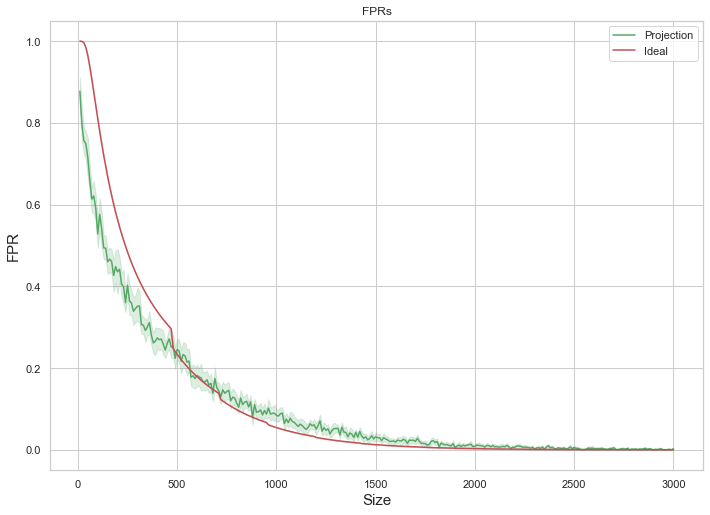

In [21]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [22]:
average_fprs = num_of_iterations*average_fprs
print(len(average_fprs))

6000


In [23]:
average_times = num_of_iterations*average_times
print(len(average_times))

6000


In [24]:
print(average_fprs)

[0.8775362318840578, 0.7971014492753624, 0.7565217391304347, 0.7492753623188405, 0.7152173913043478, 0.660144927536232, 0.613768115942029, 0.6210144927536232, 0.5913043478260869, 0.5282608695652173, 0.5760869565217391, 0.5391304347826087, 0.4942028985507247, 0.49347826086956514, 0.4601449275362318, 0.4666666666666666, 0.4608695652173913, 0.42681159420289855, 0.44855072463768125, 0.4355072463768116, 0.4420289855072463, 0.4057971014492754, 0.39927536231884064, 0.36014492753623195, 0.4028985507246377, 0.36449275362318845, 0.35942028985507246, 0.3391304347826086, 0.3456521739130435, 0.35144927536231885, 0.35217391304347834, 0.3065217391304348, 0.305072463768116, 0.2920289855072464, 0.30072463768115937, 0.31159420289855067, 0.2811594202898551, 0.26159420289855073, 0.26594202898550723, 0.2739130434782609, 0.2695652173913043, 0.2710144927536232, 0.2586956521739131, 0.24420289855072466, 0.26014492753623186, 0.27173913043478265, 0.25144927536231887, 0.2536231884057972, 0.22391304347826094, 0.24

In [25]:
saved_data = list(zip(size_values, y_ideal, standard_times, average_standard_times, fpr_values, average_fprs, times, average_times))
df = pd.DataFrame(saved_data,columns = ['Size of filter(bits)','Ideal FPR','Standard Filter Total Creation Time(sec)', 'Average Standard Filter Total Creation Time(sec)', 'Projection FPR for iteration', 'Average Projection FPR', 'Projection Filter Total Creation Time(sec)', 'Average Projection Filter Total Creation Time(sec)'])
df.head()

,Size of filter(bits),Ideal FPR,Standard Filter Total Creation Time(sec),Average Standard Filter Total Creation Time(sec),Projection FPR for iteration,Average Projection FPR,Projection Filter Total Creation Time(sec),Average Projection Filter Total Creation Time(sec)
0,10,1.000000,0.001326,0.000786,0.840580,0.877536,0.040757,0.041109
1,20,0.999789,0.000759,0.000768,0.869565,0.797101,0.040350,0.040974
2,30,0.996279,0.000747,0.000846,0.623188,0.756522,0.040009,0.041209
3,40,0.984662,0.000817,0.000957,0.739130,0.749275,0.040152,0.040281
4,50,0.964330,0.000778,0.000769,0.840580,0.715217,0.041856,0.040615


In [28]:
df.to_csv('E:/SURA Data/Heart_rerun_epochs_100.csv')